In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
from __future__ import print_function
import os                                    
import sys
import keras
import tensorflow as tf
import numpy as np 
from matplotlib import pyplot
import warnings
warnings.filterwarnings("ignore")

Using TensorFlow backend.


# BusterNet Performance On the CoMoFoD Dataset

# 1. Load the pretrained BusterNet model

In [2]:
model_dir =  '../../Model'
sys.path.insert( 0, model_dir )
from BusterNetCore import create_BusterNet_testing_model
busterNetModel = create_BusterNet_testing_model( os.path.join( model_dir, 'pretrained_busterNet.hd5' ) )

INFO: successfully load pretrained weights from ../../Model/pretrained_busterNet.hd5


# 2. Load the CoMoFoD-CMFD Dataset

In [3]:
from keras.utils.io_utils import HDF5Matrix
CoMoFoD_hd5 = 'CoMoFoD-CMFD.hd5'
# 1. load HDF5 data
X  = HDF5Matrix(CoMoFoD_hd5, 'X' )
XN = HDF5Matrix(CoMoFoD_hd5, 'XN' )
Y  = HDF5Matrix(CoMoFoD_hd5, 'Y' )
YN = HDF5Matrix(CoMoFoD_hd5, 'YN' )

In [4]:
Z = busterNetModel.predict(X, verbose=1 )

5000/5000 [==============================] - 70s 14ms/step


# 3. BusterNet Performance on CoMoFoD Dataset (Table 3)

In [5]:
from parse import parse
from sklearn.metrics import precision_recall_fscore_support

def get_target_idx( xn, ynames ) :
    fmt = '{}_F_{}'
    try :
        img_id, postproc = parse( fmt, xn )
    except :
        img_id = xn.rsplit('_')[0]
        postproc = 'BASE'
    idx = ynames.index( img_id )
    return idx, img_id, postproc

def evaluate_CoMoFoD_performance( Z, XN, Y, YN ) :
    # 1. prepare target names
    ynames = []
    for yn in YN :
        ynames.append(yn)
    # 2. evaluate performance for each sample
    plut = {'mapping':{}}
    for xidx, (xn, z) in enumerate( zip( XN, Z ) ) :
        # 3. get corresponding target file
        idx, img_id, postproc = get_target_idx( xn, ynames )
        y = Y[idx]
        # 4. evaluate performance
        if postproc not in plut :
            plut[postproc] = []
        ref = y[...,2].ravel() == 0
        hyp = z[...,2].ravel() <= 0.5
        precision, recall, fscore, _ = precision_recall_fscore_support( ref, hyp,
                                                                        pos_label=1, 
                                                                        average='binary' )
        plut[postproc].append( [precision, recall, fscore] )
        if postproc == 'BASE' :
            plut['mapping'][xidx] = [idx, fscore]
    # 5. show results
    print( "INFO: BusterNet Performance on CoMoFoD-CMFD Dataset using the number of correct detections" )
    print("-" * 100)
    for key, res in sorted( plut.items() ) :
        if key == 'mapping' :
            continue
        # a sample is correct if its F1 score is above 0.5
        nb_correct = np.sum( np.row_stack(res)[:,-1] > .5 )
        print ("{:>4s}: {:>3}".format( key, nb_correct ) )
    return plut
        

In [6]:
plut = evaluate_CoMoFoD_performance( Z, XN, Y, YN )

INFO: BusterNet Performance on CoMoFoD-CMFD Dataset using the number of correct detections
----------------------------------------------------------------------------------------------------
BASE: 126
 BC1: 125
 BC2: 123
 BC3: 115
 CA1: 125
 CA2: 124
 CA3: 123
 CR1: 126
 CR2: 125
 CR3: 125
 IB1: 122
 IB2: 108
 IB3: 100
 JC1:  65
 JC2:  82
 JC3:  93
 JC4: 110
 JC5: 105
 JC6: 108
 JC7: 114
 JC8: 119
 JC9: 112
 NA1: 110
 NA2: 111
 NA3: 124


# 4. Plot Performance Curves

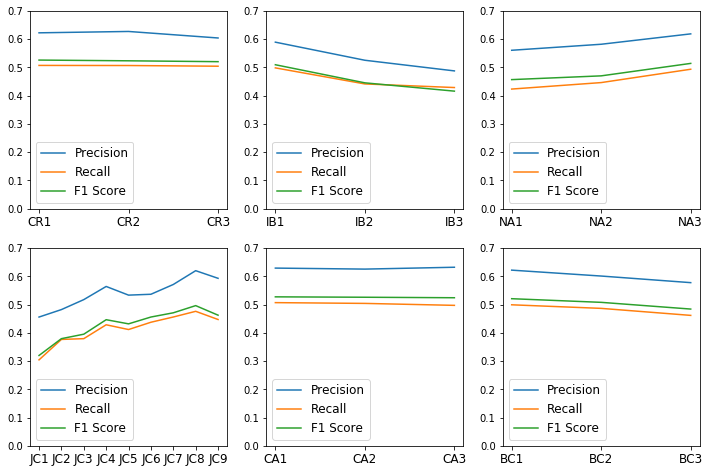

In [7]:
llut = { 'Bright Change(BC)' : range(1,4), 'Contrast Adjustment(CA)' : range(4,7),
        'Color Reduction(CR)' : range(7,10), 'Image Blurring(IB)' : range(10,13), 
        'JPEG Compression(JC)' : range(13,22), 'Noise Adding(NA)' : range(22,25) }

pyplot.figure(figsize=(12,8))
ii = 1
for key, vals in llut.items() :
    ys = []
    xnames = []
    for idx, val in enumerate(vals) :
        _, prefix = parse( '{}({})', key)
        tkey = prefix + str(idx+1)
        ys.append( np.mean( np.row_stack( plut[tkey] ), axis=0) )
        xnames.append( tkey )
    pyplot.subplot(2,3,ii)
    pyplot.plot( np.array(ys) )
    pyplot.xticks( range(len(vals)), xnames, fontsize=12 )
    pyplot.legend(['Precision', 'Recall', 'F1 Score'], fontsize=12 )
    pyplot.ylim([0,.7])
    ii += 1

# 5. Generate qualitative results

In [8]:
def visualize_random_samples( X, Y, Z, prf_lut, batch_size=4, figsize=(12,4),  thresh=0.3 ) :
    nb_samples = X.shape[0]
    ynames = []
    for yn in YN :
        ynames.append(yn)
    if prf_lut is None :
        print("INFO: show random results")
        indices = np.random.choice( prf_lut['mapping'].keys(), size=(batch_size,))
    else :
        print("INFO: show random results with F1 score > {}".format( thresh ) )
        candi = list( filter(None, [ xidx if f1>thresh else None for xidx, ( yidx, f1 ) in prf_lut['mapping'].items() ] ) )
        indices = np.random.choice( candi, size=(batch_size,))
    for idx in indices :
        # 1. add back imageNet BGR means
        x = np.array(X[idx]) + np.array([103.939, 116.779, 123.68]).reshape([1,1,3])
        # 2. restore image dtype and BGR->RGB
        x = np.round(x).astype('uint8')[...,::-1]
        # 3. set gt to float
        yidx, f1 = prf_lut['mapping'][idx]
        y = np.array(Y[yidx]).astype('float32')
        z = np.array(Z[idx])
        # 4. display
        pyplot.figure(figsize=figsize)
        pyplot.subplot(131)
        pyplot.imshow( x )
        pyplot.title('test image')
        pyplot.subplot(132)
        pyplot.imshow( y )
        pyplot.title('ground truth')
        pyplot.subplot(133)
        pyplot.imshow( z )
        pyplot.title('BusterNet predicted')
    return

INFO: show random results with F1 score > 0.5


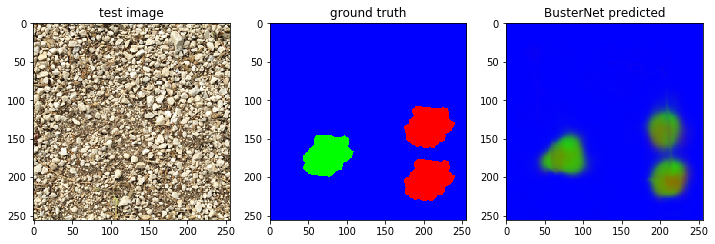

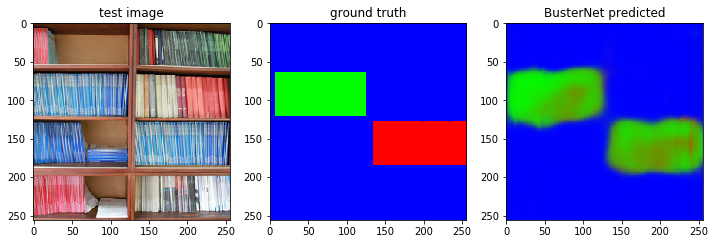

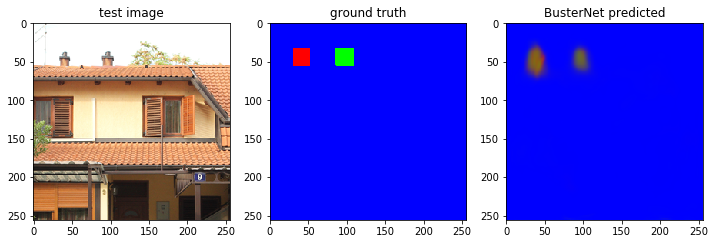

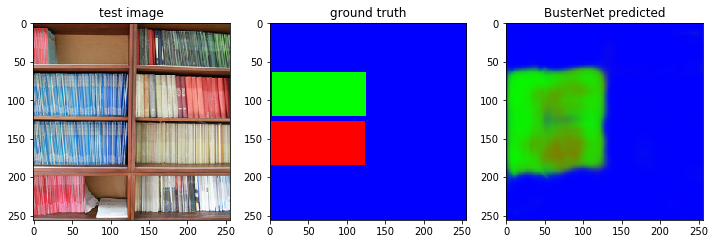

In [9]:
visualize_random_samples( X, Y, Z, prf_lut=plut, thresh=0.5 )